In [1]:
# Standard libraries

import os
import math
import time
import numpy as np


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()


## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

/dev/shm/lordzuko_4539741/ipykernel_1684963/3320227627.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/normalizing_flow"

# Setting the seed
pl.seed_everything(42)

Global seed set to 42


42

In [3]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [4]:
"""
We will use the MNIST dataset in this notebook. 
MNIST constitutes, despite its simplicity, a challenge for small generative models as it 
requires the global understanding of an image. At the same time, we can easily judge whether 
generated images come from the same distribution as the dataset (i.e. represent real digits), or not.

To deal better with the discrete nature of the images, we transform them from a range of 0-1 
to a range of 0-255 as integers.
"""

# Convert images from 0-1 to 0-255 (integers)
def discretize(sample):
    return (sample * 255).to(torch.int32)


# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=False)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=False)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

Global seed set to 42


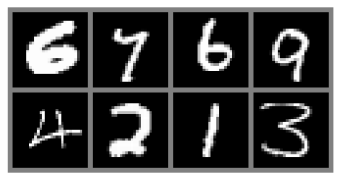

In [5]:
def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

# Normalizing Flow

* Energy-Based models only learns the probability density implicitly
* Variational Autoencoders (VAEs) models a lower bound on probability density function p(x) of the real input.
* GANs provides a sampling mechanism for generating new data - however we cannot get a likelihood estimate

None of these models explicitly models the probability density function p(x) of the real input.
* Normalizing flow models the true data probability distribution p(x) and provides exact likelihood estimate.

In [6]:
class ImageFlow(pl.LightningModule):
    
    def __init__(self, flows, import_samples=8):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images.
            import_samples - Number of importance samples to use during testing (see explanation below). Can be changed at any time
        """
        
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        
        # Example input for visualizing the graph
        self.example_input_array = train_set[0][0].unsqueeze(dim=0)
        
    def forward(self, imgs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(imgs)
    
    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        # ldj => log determinant jacobian
        
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
            
        return z, ldj
    
    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood of those.
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        
        z, ldj = self.encode(imgs)        
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        
        nll = -log_px
        
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px


    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)
            
        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        # Perform importance sampling during testing => estimate likelihood M times for each image
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)

        # To average the probabilities, we need to go from log-space to exp, and back to log.
        # Logsumexp provides us a stable implementation for this
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)
        # averaging in log domain is subtracting by log(denominator) i.e. log(total count)

        # Calculate final bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()

        self.log('test_bpd', bpd)

In [7]:
class Dequantization(nn.Module):
    #TODO: Check how the dequantization actually work by working out its math
    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input.
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """        
        super().__init__()
        self.alpha = alpha
        self.quants = quants
        
    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj
    
    
    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = torch.sigmoid(z)
            # Reversing scaling for numerical stability
            ldj -= np.log(1 - self.alpha) * np.prod(z.shape[1:])
            z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
            z = torch.log(z) - torch.log(1-z)
        return z, ldj
            
            
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)
        return z, ldj

In [8]:
"""
A good check whether a flow is correctly implemented or not, is to verify that it is invertible. 
Hence, we will dequantize a randomly chosen training image, and then quantize it again. 
We would expect that we would get the exact same image out:
"""

## Testing invertibility of dequantization layer
pl.seed_everything(42)
orig_img = train_set[0][0].unsqueeze(dim=0)
ldj = torch.zeros(1,)
dequant_module = Dequantization()
deq_img, ldj = dequant_module(orig_img, ldj, reverse=False)
reconst_img, ldj = dequant_module(deq_img, ldj, reverse=True)

d1, d2 = torch.where(orig_img.squeeze() != reconst_img.squeeze())
if len(d1) != 0:
    print("Dequantization was not invertible.")
    for i in range(d1.shape[0]):
        print("Original value:", orig_img[0,0,d1[i], d2[i]].item())
        print("Reconstructed value:", reconst_img[0,0,d1[i], d2[i]].item())
else:
    print("Successfully inverted dequantization")

# Layer is not strictly invertible due to float precision constraints
assert (orig_img == reconst_img).all().item()

Global seed set to 42


Successfully inverted dequantization


The test succeeds as we would expect. However, there is a chance that the test fails due to numerical inaccuracies in the sigmoid invert. While the input space to the inverted sigmoid is scaled between 0 and 1, the output space is between and . And as we use 32 bits to represent the numbers (in addition to applying logs over and over again), such inaccuries can occur and should not be worrisome. Nevertheless, it is good to be aware of them, and can be improved by using a double tensor (float64).

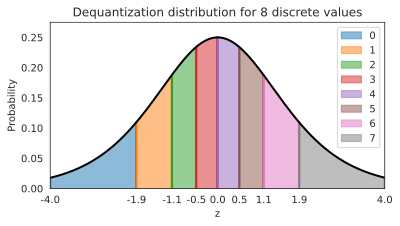

In [9]:
def visualize_dequantization(quants, prior=None):
    """
    Function for visualizing the dequantization values of discrete values in continuous space
    """
    # Prior over discrete values. If not given, a uniform is assumed
    if prior is None:
        prior = np.ones(quants, dtype=np.float32) / quants
    prior = prior / prior.sum()  # Ensure proper categorical distribution

    inp = torch.arange(-4, 4, 0.01).view(-1, 1, 1, 1) # Possible continuous values we want to consider
    ldj = torch.zeros(inp.shape[0])
    dequant_module = Dequantization(quants=quants)
    # Invert dequantization on continuous values to find corresponding discrete value
    out, ldj = dequant_module.forward(inp, ldj, reverse=True)
    inp, out, prob = inp.squeeze().numpy(), out.squeeze().numpy(), ldj.exp().numpy()
    prob = prob * prior[out] # Probability scaled by categorical prior

    # Plot volumes and continuous distribution
    sns.set_style("white")
    fig = plt.figure(figsize=(6,3))
    x_ticks = []
    for v in np.unique(out):
        indices = np.where(out==v)
        color = to_rgb(f"C{v}")
        plt.fill_between(inp[indices], prob[indices], np.zeros(indices[0].shape[0]), color=color+(0.5,), label=str(v))
        plt.plot([inp[indices[0][0]]]*2,  [0, prob[indices[0][0]]],  color=color)
        plt.plot([inp[indices[0][-1]]]*2, [0, prob[indices[0][-1]]], color=color)
        x_ticks.append(inp[indices[0][0]])
    x_ticks.append(inp.max())
    plt.xticks(x_ticks, [f"{x:.1f}" for x in x_ticks])
    plt.plot(inp,prob, color=(0.0,0.0,0.0))
    # Set final plot properties
    plt.ylim(0, prob.max()*1.1)
    plt.xlim(inp.min(), inp.max())
    plt.xlabel("z")
    plt.ylabel("Probability")
    plt.title(f"Dequantization distribution for {quants} discrete values")
    plt.legend()
    plt.show()
    plt.close()

visualize_dequantization(quants=8)

In [10]:
class VariationalDequantization(Dequantization):

    def __init__(self, var_flows, alpha=1e-5):
        """
        Inputs:
            var_flows - A list of flow transformations to use for modeling q(u|x)
            alpha - Small constant, see Dequantization for details
        """
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)

    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (z / 255.0) * 2 - 1 # We condition the flows on x, i.e. the original image

        # Prior of u is a uniform distribution as before
        # As most flow transformations are defined on [-infinity,+infinity], we apply an inverse sigmoid first.
        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)

        # After the flows, apply u as in standard dequantization
        z = (z + deq_noise) / 256.0
        ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj

## Coupling layers

- possible transformations to apply inside the flow
- flow layer, which works well in combination with deep neural networks, is the coupling layer

- here: affine coupling



we will realize the splitting of variables as masking. The variables to be transformed, , are masked when passing to the shared network to predict the transformation parameters. When applying the transformation, we mask the parameters for so that we have an identity operation for those variables:

In [11]:
class CouplingLayer(nn.Module):

    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter,
        # but should be part of the modules state.
        self.register_buffer('mask', mask)
        
    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows.
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)
        
        
        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac
        
        
        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        
        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])

        return z, ldj

For stabilization purposes, we apply a activation function on the scaling output. This prevents sudden large output values for the scaling that can destabilize training. To still allow scaling factors smaller or larger than -1 and 1 respectively, we have a learnable parameter per dimension, called `scaling_factor`. This scales the tanh to different limits. Below, we visualize the effect of the scaling factor on the output activation of the scaling terms:

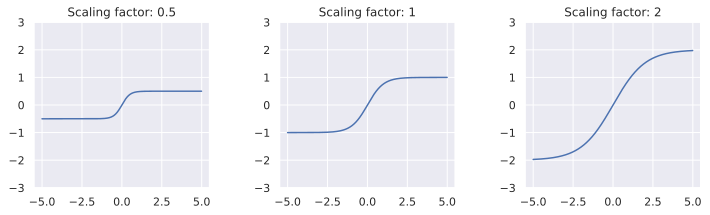

In [12]:
with torch.no_grad():
    x = torch.arange(-5,5,0.01)
    scaling_factors = [0.5, 1, 2]
    sns.set()
    fig, ax = plt.subplots(1, 3, figsize=(12,3))
    for i, scale in enumerate(scaling_factors):
        y = torch.tanh(x / scale) * scale
        ax[i].plot(x.numpy(), y.numpy())
        ax[i].set_title("Scaling factor: " + str(scale))
        ax[i].set_ylim(-3, 3)
    plt.subplots_adjust(wspace=0.4)
    sns.reset_orig()
    plt.show()

Coupling layers generalize to any masking technique we could think of. However, the most common approach for images is to split the input in half, using a checkerboard mask or channel mask. A checkerboard mask splits the variables across the height and width dimensions and assigns each other pixel to . Thereby, the mask is shared across channels. In contrast, the channel mask assigns half of the channels to , and the other half to . Note that when we apply multiple coupling layers, we invert the masking for each other layer so that each variable is transformed a similar amount of times.

In [13]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask


def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in//2, dtype=torch.float32),
                      torch.zeros(c_in-c_in//2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

We can also visualize the corresponding masks for an image of size (2 channels):

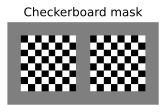

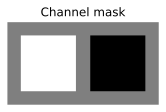

In [14]:
checkerboard_mask = create_checkerboard_mask(h=8, w=8).expand(-1,2,-1,-1)
channel_mask = create_channel_mask(c_in=2).expand(-1,-1,8,8)

show_imgs(checkerboard_mask.transpose(0,1), "Checkerboard mask")
show_imgs(channel_mask.transpose(0,1), "Channel mask")

As a last aspect of coupling layers, we need to decide for the deep neural network we want to apply in the coupling layers. The input to the layers is an image, and hence we stick with a CNN. Because the input to a transformation depends on all transformations before, it is crucial to ensure a good gradient flow through the CNN back to the input, which can be optimally achieved by a ResNet-like architecture. Specifically, we use a Gated ResNet that adds a -gate to the skip connection, similarly to the input gate in LSTMs. The details are not necessarily important here, and the network is strongly inspired from Flow++ [3] in case you are interested in building even stronger models.

In [15]:
class ConcatELU(nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain).
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """

    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)


class LayerNormChannels(nn.Module):

    def __init__(self, c_in, eps=1e-5):
        """
        This module applies layer norm across channels in an image.
        Inputs:
            c_in - Number of channels of the input
            eps - Small constant to stabilize std
        """
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y


class GatedConv(nn.Module):

    def __init__(self, c_in, c_hidden):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(nn.Module):

    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden),
                       LayerNormChannels(c_hidden)]
        layers += [ConcatELU(),
                   nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

    def forward(self, x):
        return self.nn(x)

## Training Loop

Finally, we can add Dequantization, Variational Dequantization and Coupling Layers together to build our full normalizing flow on MNIST images. We apply 8 coupling layers in the main flow, and 4 for variational dequantization if applied. We apply a checkerboard mask throughout the network as with a single channel (black-white images), we cannot apply channel mask. The overall architecture is visualized below.

In [16]:
def create_simple_flow(use_vardeq=True):
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                       mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                       c_in=1) for i in range(4)]
        flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
    else:
        flow_layers += [Dequantization()]

    for i in range(8):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                      mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                      c_in=1)]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

For implementing the training loop, we use the framework of PyTorch Lightning and reduce the code overhead. If interested, you can take a look at the generated tensorboard file, in particularly the graph to see an overview of flow transformations that are applied. Note that we again provide pre-trained models (see later on in the notebook) as normalizing flows are particularly expensive to train. We have also run validation and testing as this can take some time as well with the added importance sampling.

In [17]:
def train_flow(flow, model_name="MNISTFlow"):
    # Create a PyTorch Lightning trainer
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_name),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=200,
                         gradient_clip_val=1.0,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=5)
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    train_data_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
    result = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename, map_location=device)
        flow.load_state_dict(ckpt['state_dict'])
        result = ckpt.get("result", None)
    else:
        print("Start training", model_name)
        trainer.fit(flow, train_data_loader, val_loader)

    # Test best model on validation and test set if no result has been found
    # Testing can be expensive due to the importance sampling.
    if result is None:
        val_result = trainer.test(flow, val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(flow, test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}

    return flow, result

In [18]:
flow = create_simple_flow()

In [19]:
flow

ImageFlow(
  (flows): ModuleList(
    (0): VariationalDequantization(
      (flows): ModuleList(
        (0): CouplingLayer(
          (network): GatedConvNet(
            (nn): Sequential(
              (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): GatedConv(
                (net): Sequential(
                  (0): ConcatELU()
                  (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                  (2): ConcatELU()
                  (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
                )
              )
              (2): LayerNormChannels()
              (3): GatedConv(
                (net): Sequential(
                  (0): ConcatELU()
                  (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                  (2): ConcatELU()
                  (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
                )
              )
              (4): LayerN

In [ ]:
trained_flow, result = train_flow(flow, model_name="MNISTFlow")

Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Start training MNISTFlow


/work/tc046/tc046/lordzuko/miniconda3/envs/pdl/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory ../saved_models/normalizing_flow/MNISTFlow/lightning_logs/version_4539741/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | flows | ModuleList | 628 K  | ?        | ?        
------------------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.514     Total estimated model params size (MB)
/work/tc046/tc046/lordzuko/miniconda3/envs/pdl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python valu

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]